## General Imports
All numerical calculations are done with numpy.
Futher functionality for plotting is hidden in utils.py.
Finally, to calculate the tube shape, a module library called `pyctr` is used, which was developed by the authors and can be found [here](https://github.com/IRP-TU-BS/pyctr).

In [1]:
import numpy as np

## Local Imports

In [2]:
from utils import *

## CTR Imports

In [3]:
from pyctr.cosserat_rod import *

## Build Model Tubes
The following cell detemines the curature of the tubes or a 2-tube CTR. Futhermore, the sample density along the tubes body can be defined by the step_size.
Finally, the tube parameters are set.

In [4]:
ROD1_CURVATURE = 6.0
ROD2_CURVATURE = 6.0

STEP_SIZE = 0.001

In [5]:
ROD1_PARAMS = {
    "kappa": ROD1_CURVATURE,
    "L": 150.0 * 1e-3,
    "straight_length": 0.05,
}
ROD2_PARAMS = {
    "kappa": ROD2_CURVATURE,
    "r_inner": 1.5 * 1e-3,
    "r_outer": 2.5 * 1e-3,
    "L": 120.0 * 1e-3,
    "straight_length": 80.0 * 1e-3,
}

### Create tubes 
The following section is creatig the tube and CTR objects eeded for calulating the robots shape.

#### Curved tubes
First a set of curved tubes is created and with those tubes, a CTR is generated.

In [6]:
curved_rod1 = create_rod(ROD1_PARAMS)
curved_rod2 = create_rod(ROD2_PARAMS)

In [7]:
# Please be not confused. The wrapper is used to decorate the tubes with additional functionality such as push_end, which enables the application of a force to the tip of the tubes.
curved_rod1_ctr = create_ctr_wrapper([curved_rod1])
curved_rod2_ctr = create_ctr_wrapper([curved_rod2])

In [8]:
ctr = create_ctr_wrapper([curved_rod1, curved_rod2])

#### Straight
Additionally, straight tubes with the same properties are created.

In [9]:
ROD1_PARAMS["kappa"] = 0
ROD2_PARAMS["kappa"] = 0

In [10]:
straight_rod1 = create_rod(ROD1_PARAMS)
straight_rod2 = create_rod(ROD2_PARAMS)

In [11]:
straight_rod1_ctr = create_ctr_wrapper([straight_rod1])
straight_rod2_ctr = create_ctr_wrapper([straight_rod2])

In [12]:
straight_ctr = create_ctr_wrapper([straight_rod1, straight_rod2])

### Create instances geometry of the robots
For plotting the shape of the tubes, we calculate the tubes shape when no force is applied to there tips.

In [13]:
from ctr_diffeomorphism import create_extended_copy_of_tube

In [14]:
crod1_pos, crod1_ori = curved_rod1_ctr.push_end(np.zeros(6), STEP_SIZE)[0:2]
crod2_pos, crod2_ori = curved_rod2_ctr.push_end(np.zeros(6), STEP_SIZE)[0:2]

In [15]:
srod1_pos = straight_rod1_ctr.push_end(np.zeros(6), STEP_SIZE)[0]
srod2_pos = straight_rod2_ctr.push_end(np.zeros(6), STEP_SIZE)[0]

We use a special function to extend the second tube, which is smaller than the first, by a straight section at its end until the extend tube has the same length as the first one. 

In [16]:
crod2_ext_pos = create_extended_copy_of_tube(crod2_pos, crod2_ori, crod1_pos.shape[0], STEP_SIZE)

### Find the diffeomorphism
For both tubes we find the paramters for a diffeomorphic mapping between straight and curved tube intances.

In [17]:
from ctr_diffeomorphism import *

In [18]:
# First diifeo step
p1, c1, v1 = find_diffeo_map(srod1_pos, crod1_pos, K=25, beta=0.4)
p1 = p1.reshape(-1, 1)
c1 = np.array(c1).reshape(-1, 1)

In [19]:
# Second diffeo step
p2, c2, v2 = find_diffeo_map(srod2_pos, crod2_pos, K=25, beta=0.4)
p2 = p2.reshape(-1, 1)
c2 = np.array(c2).reshape(-1, 1)

Additionally, we get the tubes material properties.

In [20]:
E1 = curved_rod1.params["E"]
I1 = curved_rod1.params["I"]
EI1 = E1*I1 
L1 = curved_rod1.params["L"]
E2 = curved_rod2.params["E"]
I2 = curved_rod2.params["I"]
EI2 = E2*I2
L2 = curved_rod2.params["L"]

### Use the diffeomorphic mapping
Given all parameters for the diffeomorphic mapping, we apply it to transform data of the straight tube to a curved instance

In [21]:
diffeo_1 = do_forward_diffeo(srod1_pos, [0], [0.], p1, c1, v1, [EI1], [L1])
diffeo_2 = do_forward_diffeo(srod2_pos, [0], [0.], p2, c2, v2, [EI2], [L2])

[0]
[0]


#### Plot the results
For plotting the results we use the 3d plotting library pyvista

In [22]:
import pyvista as pv
pv.set_jupyter_backend('static') # for inteactive view set to "trame" 

In [23]:
indices, ds = get_plot_len_and_size(
    curved_rod1_ctr,
    crod1_pos.shape[0],
    [
        0.,
    ],
)
indicesdiff, dsdiff = get_plot_len_and_size(
    curved_rod1_ctr,
    diffeo_1.shape[0],
    [
        0.,
    ],
)

indicesdiff2, dsdiff2 = get_plot_len_and_size(
    curved_rod2_ctr,
    diffeo_2.shape[0],
    [
        0.,
    ],
)

indices2, ds2 = get_plot_len_and_size(
    curved_rod2_ctr,
    crod2_pos.shape[0],
    [
        0.,
    ],
)

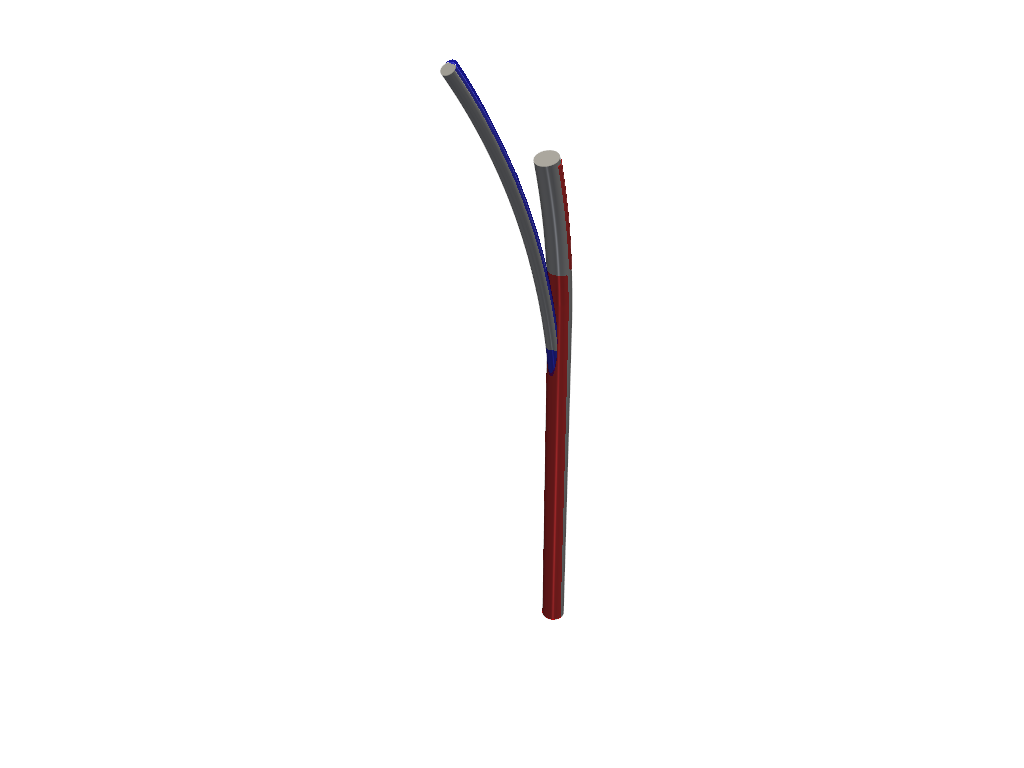

In [24]:
plotter = pv.Plotter()

plotter = simple_plot_tubes_pyvista(plotter, crod1_pos, indices, ds, "curved inner tube", 1.)
plotter = simple_plot_tubes_pyvista(plotter, diffeo_1, indices, ds, "diffeomorphism for inner tube", 0.7, color="blue")
plotter = simple_plot_tubes_pyvista(plotter, crod2_pos, indices2, ds2, "curved inner tube2", 1)
plotter = simple_plot_tubes_pyvista(plotter, diffeo_2, indicesdiff2, dsdiff2, "diffeomorphism for inner tube2", 0.7, color="red")


# Set the camera position
plotter.camera_position = "iso"  # Isometric view

# Display the plot
plotter.show()

### Use the diffeomorphic mapping with rotation and retraction
The next example takes the same tubes and rotates and retracts them.

In [25]:
ALPHA=np.pi/4
BETA=0.1

In [26]:
curved_rod1_ctr.rotate([ALPHA])
curved_rod1_ctr.translate([BETA])
tube_1_curved_data = curved_rod1_ctr.push_end(np.zeros(6),STEP_SIZE)[0]

curved_rod2_ctr.rotate([-ALPHA])
curved_rod2_ctr.translate([BETA])
tube_2_curved_data = curved_rod2_ctr.push_end(np.zeros(6),STEP_SIZE)[0]

straight_rod1_ctr.rotate([ALPHA])
straight_rod1_ctr.translate([BETA])
tube_1_straight_data = straight_rod1_ctr.push_end(np.zeros(6),STEP_SIZE)[0]

straight_rod2_ctr.rotate([-ALPHA])
straight_rod2_ctr.translate([BETA])
tube_2_straight_data = straight_rod2_ctr.push_end(np.zeros(6),STEP_SIZE)[0]

In [27]:
diffeo_1 = do_forward_diffeo(srod1_pos, [ALPHA], [BETA], p1, c1, v1, [EI1], [L1])
diffeo_2 = do_forward_diffeo(srod2_pos, [-ALPHA], [BETA], p2, c2, v2, [EI2], [L2])

[0]
[0]


In [28]:
indices, ds = get_plot_len_and_size(
    curved_rod1_ctr,
    crod1_pos.shape[0],
    [
        BETA,
    ],
)
indicesdiff, dsdiff = get_plot_len_and_size(
    curved_rod1_ctr,
    diffeo_1.shape[0],
    [
        BETA,
    ],
)

indicesdiff2, dsdiff2 = get_plot_len_and_size(
    curved_rod2_ctr,
    diffeo_2.shape[0],
    [
        BETA,
    ],
)

indices2, ds2 = get_plot_len_and_size(
    curved_rod2_ctr,
    crod2_pos.shape[0],
    [
        BETA,
    ],
)

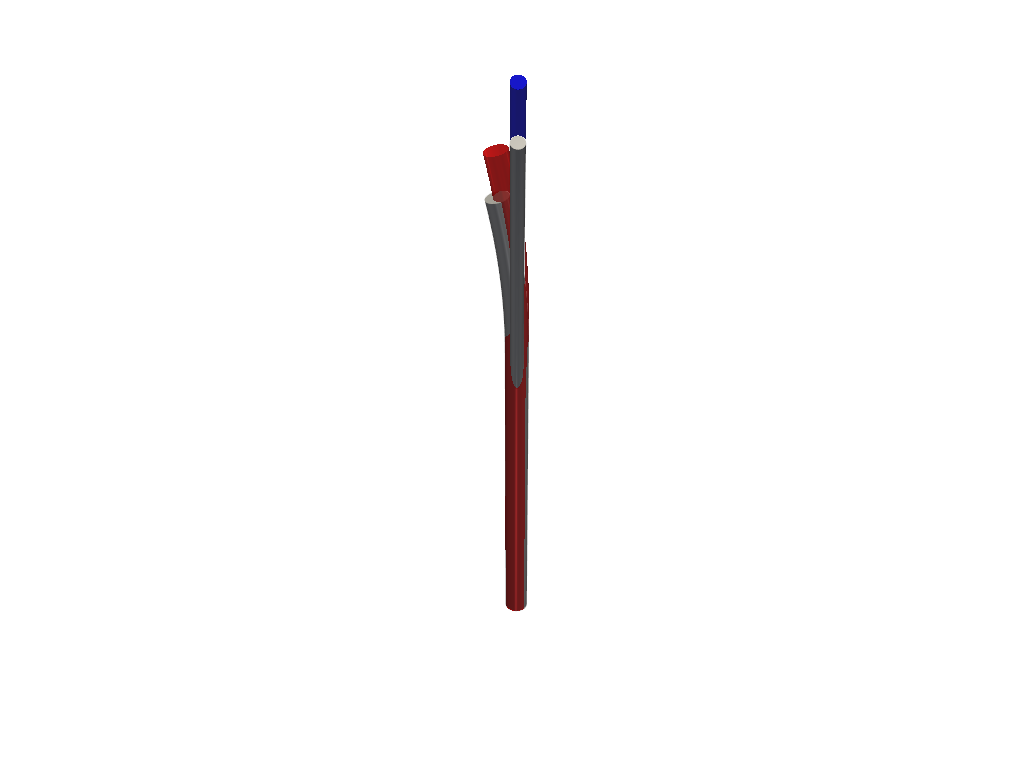

In [29]:
plotter = pv.Plotter()

plotter = simple_plot_tubes_pyvista(plotter, tube_1_curved_data, indices, ds, "curved inner tube", 1.)
plotter = simple_plot_tubes_pyvista(plotter, diffeo_1, indices, ds, "diffeomorphism for inner tube", 0.7, color="blue")
plotter = simple_plot_tubes_pyvista(plotter, tube_2_curved_data, indices2, ds2, "curved inner tube2", 1)
plotter = simple_plot_tubes_pyvista(plotter, diffeo_2, indicesdiff2, dsdiff2, "diffeomorphism for inner tube2", 0.7, color="red")


# Set the camera position
plotter.camera_position = "iso"  # Isometric view

# Display the plot
plotter.show()

### Use the inverse diffeomorphic mapping with rotation and retraction

In [30]:
diffeo_1 = do_inverse_diffeo(tube_1_curved_data, [ALPHA], [BETA], p1, c1, v1, [EI1], [L1])
diffeo_2 = do_inverse_diffeo(tube_2_curved_data, [-ALPHA], [BETA], p2, c2, v2, [EI2], [L2])

[0]
[0]


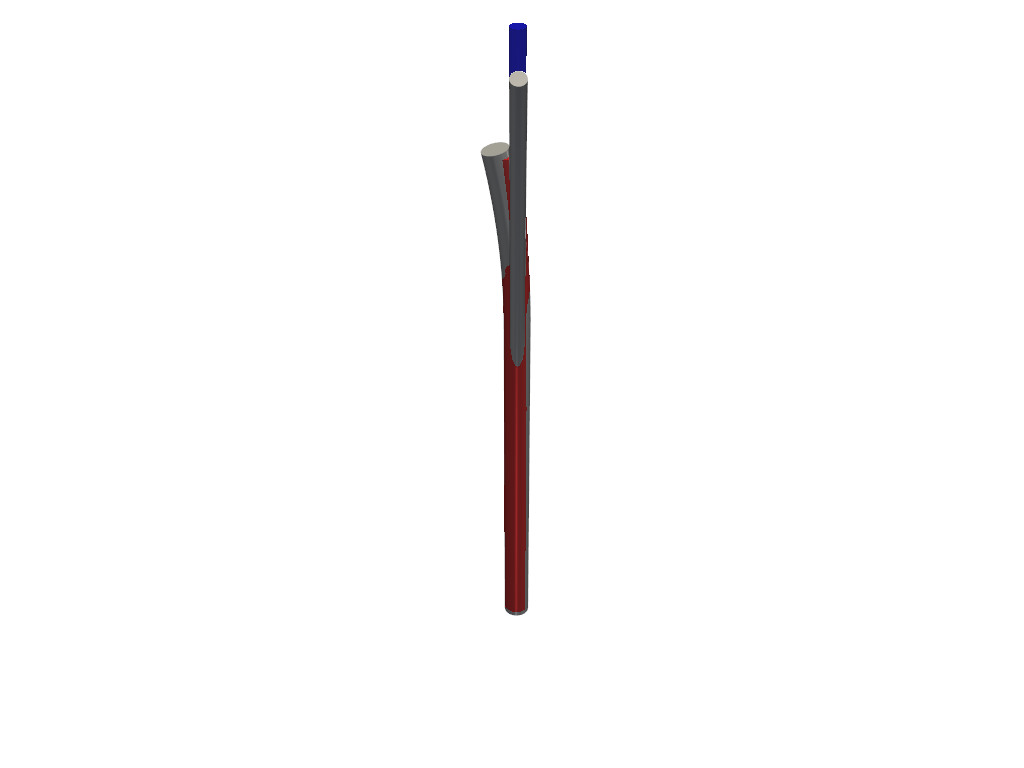

In [31]:
plotter = pv.Plotter()

plotter = simple_plot_tubes_pyvista(plotter, tube_1_curved_data, indices, ds, "curved inner tube", 1.)
plotter = simple_plot_tubes_pyvista(plotter, diffeo_1, indices, ds, "diffeomorphism for inner tube", 0.7, color="blue")
plotter = simple_plot_tubes_pyvista(plotter, tube_2_curved_data, indices2, ds2, "curved inner tube2", 1)
plotter = simple_plot_tubes_pyvista(plotter, diffeo_2, indicesdiff2, dsdiff2, "diffeomorphism for inner tube2", 0.7, color="red")


# Set the camera position
plotter.camera_position = "iso"  # Isometric view

# Display the plot
plotter.show()

## Diffeomorphism for whole robot

In [32]:
p2, c2, v2 = find_diffeo_map(srod1_pos, crod2_ext_pos, K=25, beta=0.4)
p2 = p2.reshape(-1, 1)
c2 = np.array(c2).reshape(-1, 1)

In [35]:
straight_ctr.rotate([0,0])
straight_ctr.translate([0,0])

sctr_pos = straight_ctr.push_end(np.zeros(6),STEP_SIZE)[0]

In [36]:
ctr.rotate([0, 0])
ctr.translate([0,0])
straight_ctr.rotate([0,0])
straight_ctr.translate([0,0])

alphas = [-np.pi/4,np.pi/2]
betas = [0,0]
ctr.rotate(alphas)
ctr.translate(betas)
straight_ctr.rotate(alphas)
straight_ctr.translate(betas)
sctr_pos = straight_ctr.push_end(np.zeros(6), STEP_SIZE)[0]
cctr_pos = ctr.push_end(np.zeros(6), STEP_SIZE)[0]

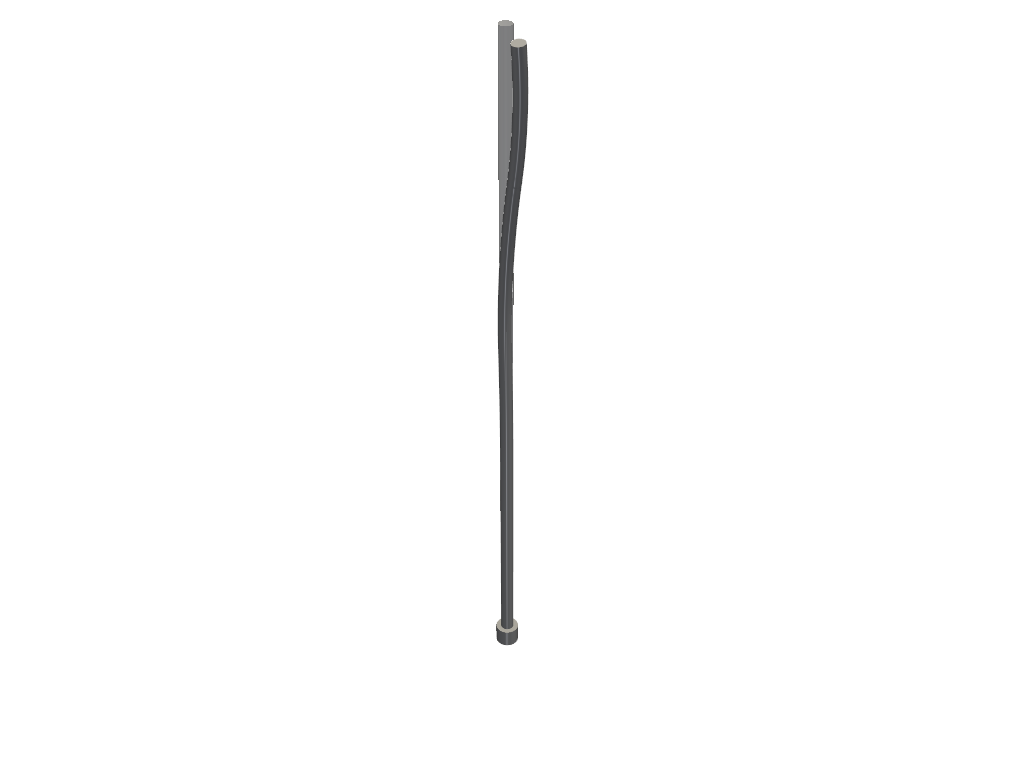

In [42]:
indices, ds = get_plot_len_and_size(
    straight_ctr,
    sctr_pos.shape[0],
     betas
)
curved_indices, curved_ds = get_plot_len_and_size(
    ctr,
    cctr_pos.shape[0],
    betas
)

plotter = pv.Plotter()

plotter = simple_plot_tubes_pyvista(plotter, sctr_pos, indices, ds, "straight tubes", 0.5)
plotter = simple_plot_tubes_pyvista(plotter, cctr_pos, curved_indices, curved_ds, "curved_tubes", 1)
#plotter.add_points(cctr_pos, color='red', point_size=20, render_points_as_spheres=True)

# Set the camera position
plotter.camera_position = "iso"  # Isometric view

# Display the plot
plotter.show()

In [39]:
diffeo_cpos = do_forward_diffeo(sctr_pos, alphas, betas, np.hstack([p1,p2]),  np.hstack([c1,c2]),  np.hstack([v1,v2]), [EI1, EI2], [L1, L2])

[0, 120]


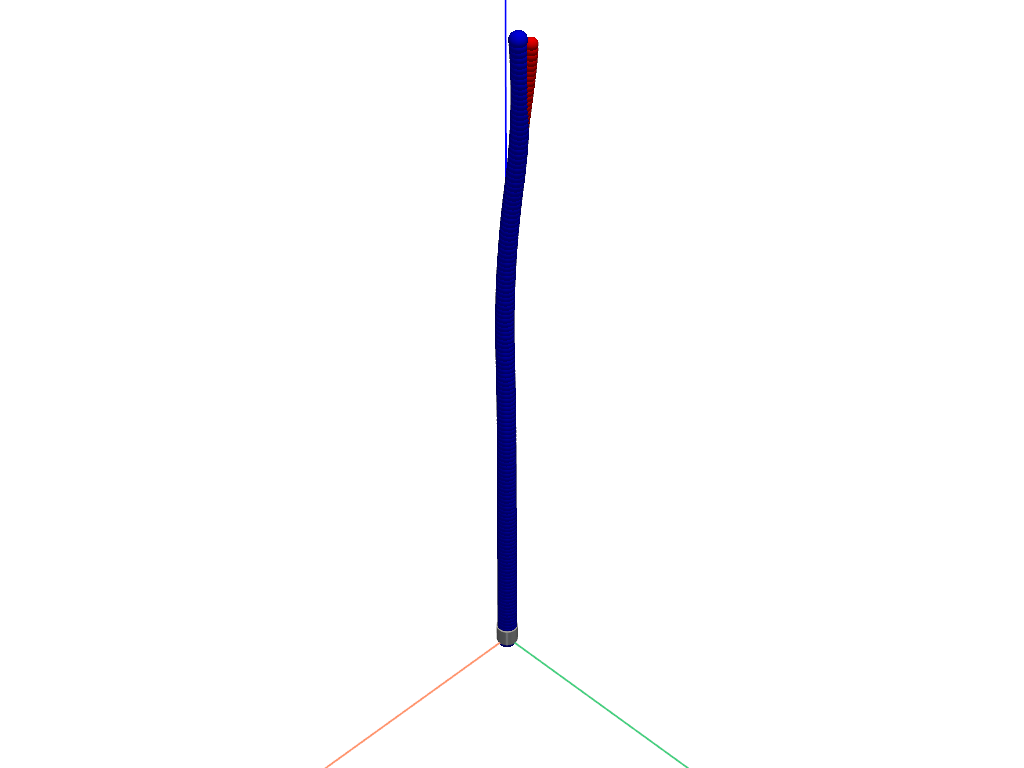

In [41]:
indices, ds = get_plot_len_and_size(
    ctr,
    sctr_pos.shape[0],
    betas
)

diffeo_indices, diffeo_ds = get_plot_len_and_size(
    ctr,
    diffeo_cpos.shape[0],
    betas
)

curved_indices, curved_ds = get_plot_len_and_size(
    ctr,
    cctr_pos.shape[0],
    betas
)


plotter = pv.Plotter()
#plotter = simple_plot_tubes_pyvista(plotter, sctr_pos, indices, ds, "straight tubes", 0.5)

#plotter = simple_plot_tubes_pyvista(plotter, diffeo_cpos, diffeo_indices, diffeo_ds, "diffeo tubes", 0.5)
plotter = simple_plot_tubes_pyvista(plotter, cctr_pos, curved_indices, curved_ds, "curved_tubes", 1)
plotter.add_points(cctr_pos, color='blue', point_size=20, render_points_as_spheres=True)

plotter.add_points(diffeo_cpos, color='red', point_size=15, render_points_as_spheres=True)

# Set the camera position
plotter.camera_position = "iso"  # Isometric view
_ = plotter.add_mesh(pv.Sphere(center=(2, 0, 0)), color='r')
_ = plotter.add_mesh(pv.Sphere(center=(0, 2, 0)), color='g')
_ = plotter.add_mesh(pv.Sphere(center=(0, 0, 2)), color='b')
_ = plotter.add_axes_at_origin()
# Display the plot
plotter.show()

In [ ]:
diffeo_cpos.shape

## 

In [ ]:
np.hstack([c1,c2])